# Predict Future Sales

We are asking you to predict total sales for every product and store in the next month. By solving this competition you will be able to apply and enhance your data science skills.

Поля данных\
ID - идентификатор, представляющий кортеж (Магазин, товар) в тестовом наборе\
shop_id - уникальный идентификатор магазина\
item_id - уникальный идентификатор продукта\
item_category_id - уникальный идентификатор категории товара\
item_cnt_day - количество проданных товаров. Вы прогнозируете ежемесячную сумму этой меры\
item_price - текущая цена товара\
date - дата в формате dd/mm/yyyy
data_block_num - последовательный номер месяца, используемый для удобства. Январь 2013 года-0, Февраль 2013 года-1,..., Октябрь 2015 года-33\
item_name - название товара\
shop_name - название магазина\
item_category_name - имя категории товара

In [2]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn import preprocessing
warnings.filterwarnings('ignore')
from pylab import rcParams
rcParams['figure.figsize'] = 15, 12
from sklearn.model_selection import GridSearchCV, train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler,MinMaxScaler

# 1 Подготовительный этап

## Чтение данных

sales_train.csv - обучающий набор. Ежедневные исторические данные с января 2013 года по октябрь 2015 года. \
test.csv - набор тестов. Вам необходимо спрогнозировать продажи этих магазинов и продуктов на ноябрь 2015 года.\
items.csv - дополнительная информация о товарах / продуктах.\
item_categories.csv - дополнительная информация о категориях элементов.\
shops.csv - дополнительная информация о магазинах.

In [154]:
items  = pd.read_csv('data/items.csv')
train = pd.read_csv('data/sales_train.csv')
test = pd.read_csv('data/test.csv')
item_category = pd.read_csv('data/item_categories.csv')
shops = pd.read_csv('data/shops.csv')

## Вспомогательные функции

Функция для анализа содержимого в dataframe

In [155]:
def show_data_info(data):
    print("-----------------Первые 7 записей----------------------")
    print(data.head(7))
    print("--------------------Информация-------------------------")
    print(data.info())
    print("-------------------Типы данных-------------------------")
    print(data.dtypes)
    print("--------------------Пропуски---------------------------")
    print(data.isnull().sum())
    print("-----------------Значнеия NULL-------------------------")
    print(data.isna().sum())
    print("----------------Форма данных---------------------------")
    print(data.shape)

Функция для удаления повторов

In [156]:
def delete_duplicate(data, subset):
    print('До удаления:', data.shape)
    before = data.shape[0]
    data.drop_duplicates(subset,keep='first', inplace=True)
    data.reset_index(drop=True, inplace=True)
    print('После удаления:', data.shape)
    after = data.shape[0]
    print('Удалено:', before-after)

 Функция для вывода на экран метрик модели

In [157]:
def show_metrics(y_real, y_predicted):
    print(f'MSE: {mean_squared_error(y_real, y_predicted)}')
    print(f'RMSE: {mean_squared_error(y_real, y_predicted, squared=False)}')
    print(f'MAE: {mean_absolute_error(y_real, y_predicted)}')
    print(f'Коэффициент детерминации: {r2_score(y_real, y_predicted)}')

Функция для вывода на экран визуализации качества модели

In [158]:
def plot_model_results(model_name, y_real, y_predicted):
    x_ax = range(len(y_predicted))
    plt.plot(x_ax, y_real, label="original")
    plt.plot(x_ax, y_predicted, label="predicted")

    plt.title(model_name)

    plt.legend()
    plt.show()

# 2. Анализ данных

## 2.1 Sales Train Data

In [159]:
show_data_info(train)

-----------------Первые 7 записей----------------------
         date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0
5  10.01.2013               0       25     2564      349.00           1.0
6  02.01.2013               0       25     2565      549.00           1.0
--------------------Информация-------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_

## 2.2 Test Data

In [161]:
show_data_info(test)

-----------------Первые 7 записей----------------------
   ID  shop_id  item_id
0   0        5     5037
1   1        5     5320
2   2        5     5233
3   3        5     5232
4   4        5     5268
5   5        5     5039
6   6        5     5041
--------------------Информация-------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   ID       214200 non-null  int64
 1   shop_id  214200 non-null  int64
 2   item_id  214200 non-null  int64
dtypes: int64(3)
memory usage: 4.9 MB
None
-------------------Типы данных-------------------------
ID         int64
shop_id    int64
item_id    int64
dtype: object
--------------------Пропуски---------------------------
ID         0
shop_id    0
item_id    0
dtype: int64
-----------------Значнеия NULL-------------------------
ID         0
shop_id    0
item_id    0
dtype: int64
----------------Форма

## 2.3 Item

In [162]:
show_data_info(items)

-----------------Первые 7 записей----------------------
                                           item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1  !ABBYY FineReader 12 Professional Edition Full...        1   
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   
3    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3   
4        ***КОРОБКА (СТЕКЛО)                       D        4   
5  ***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ  (UNI)         ...        5   
6           ***УДАР ПО ВОРОТАМ (UNI)               D        6   

   item_category_id  
0                40  
1                76  
2                40  
3                40  
4                40  
5                40  
6                40  
--------------------Информация-------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------

## 2.4 Item Category

In [163]:
show_data_info(item_category)

-----------------Первые 7 записей----------------------
        item_category_name  item_category_id
0  PC - Гарнитуры/Наушники                 0
1         Аксессуары - PS2                 1
2         Аксессуары - PS3                 2
3         Аксессуары - PS4                 3
4         Аксессуары - PSP                 4
5      Аксессуары - PSVita                 5
6    Аксессуары - XBOX 360                 6
--------------------Информация-------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB
None
-------------------Типы данных-------------------------
item_category_name    object
item_category_id       int64
dtype: object
--------------------Пропуски-----------------------

## 2.5 Shops

In [164]:
show_data_info(shops)

-----------------Первые 7 записей----------------------
                        shop_name  shop_id
0   !Якутск Орджоникидзе, 56 фран        0
1   !Якутск ТЦ "Центральный" фран        1
2                Адыгея ТЦ "Мега"        2
3  Балашиха ТРК "Октябрь-Киномир"        3
4        Волжский ТЦ "Волга Молл"        4
5          Вологда ТРЦ "Мармелад"        5
6      Воронеж (Плехановская, 13)        6
--------------------Информация-------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   shop_name  60 non-null     object
 1   shop_id    60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB
None
-------------------Типы данных-------------------------
shop_name    object
shop_id       int64
dtype: object
--------------------Пропуски---------------------------
shop_name    0
shop_id      0
dtype: int64
-----------------Значн

 Изучим продажу товаров в каждом из магазинов

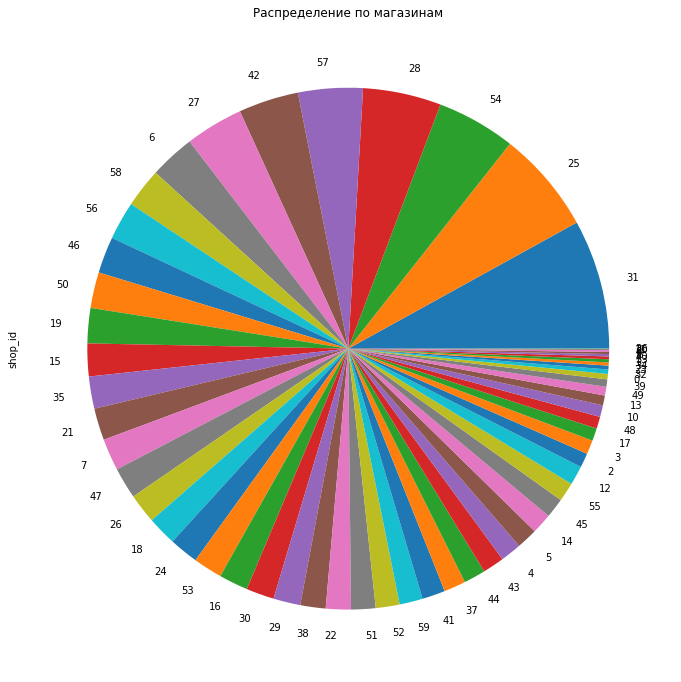

In [165]:
train["shop_id"].value_counts().plot(kind='pie')
plt.title('Распределение по магазинам');

# 3. Удаление аномалий

Удалим повторы

In [189]:
subset = ['date', 'date_block_num', 'shop_id', 'item_id','item_cnt_day']
delete_duplicate(train, subset = subset)

До удаления: (2755614, 6)
После удаления: (2755614, 6)
Удалено: 0


In [166]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
date_block_num,2935825.0,14.569921,9.422984,0.0,7.0,14.0,23.0,33.0
shop_id,2935825.0,33.001705,16.226988,0.0,22.0,31.0,47.0,59.0
item_id,2935825.0,10197.205428,6324.298134,0.0,4476.0,9343.0,15684.0,22169.0
item_price,2935825.0,890.855786,1729.806062,-1.0,249.0,399.0,999.0,307980.0
item_cnt_day,2935825.0,1.242643,2.618845,-22.0,1.0,1.0,1.0,2169.0


Удалим аномалии.

In [167]:
quantile_down = train["item_price"].quantile(0.03)
quantile_up = train["item_price"].quantile(0.97)
print('До удаления аномалий:',train.shape)

До удаления аномалий: (2935825, 6)


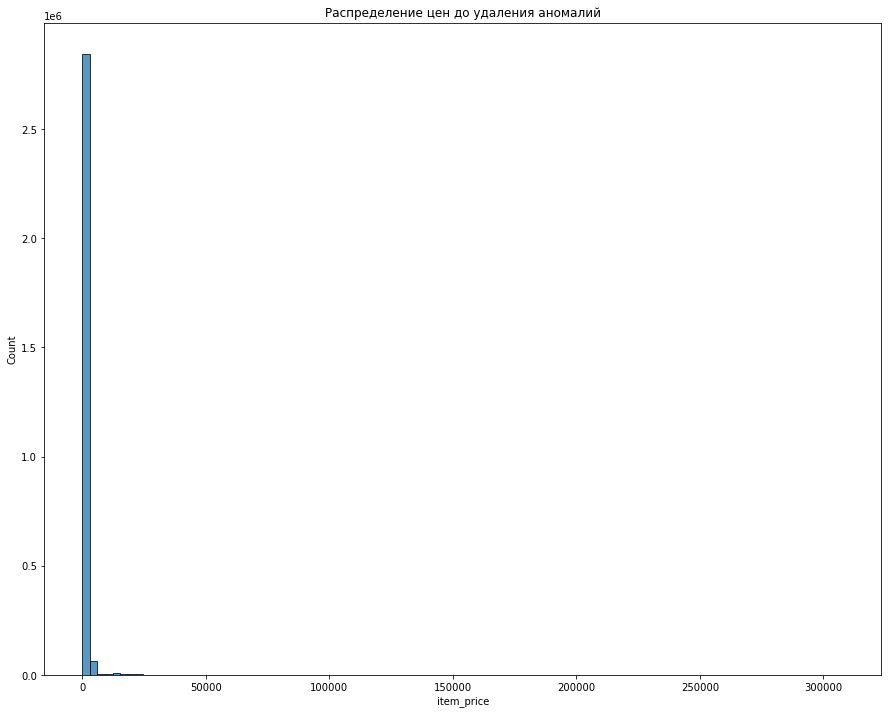

In [168]:
sns.histplot(train["item_price"], bins=100);
plt.title("Распределение цен до удаления аномалий");

In [169]:
train = train[(quantile_down < train["item_price"]) & (quantile_up > train["item_price"])]

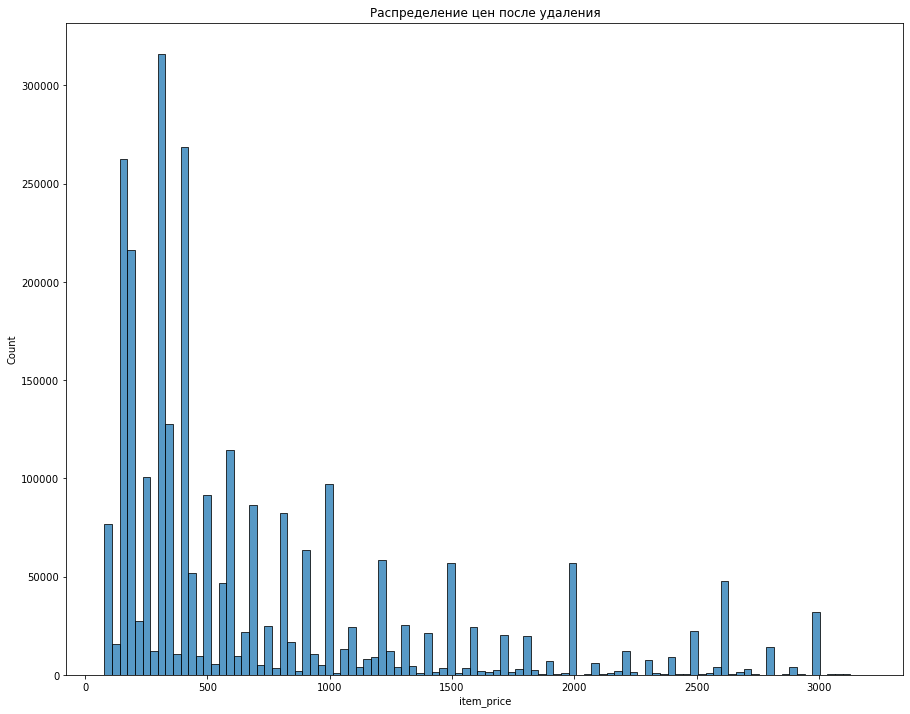

In [170]:
sns.histplot(train["item_price"], bins=100);
plt.title("Распределение цен после удаления аномалий");

In [171]:
print('Размер после удаления аномалий:',train.shape)

Размер после удаления аномалий: (2755614, 6)


In [172]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
date_block_num,2755614.0,14.401029,9.372470,0.00,6.0,13.0,22.0,33.00
shop_id,2755614.0,33.062900,16.170801,0.00,22.0,31.0,47.0,59.00
item_id,2755614.0,10118.259544,6277.845831,3.00,4380.0,9223.0,15559.0,22168.00
item_price,2755614.0,708.438170,671.747456,79.04,249.5,399.0,899.0,3189.98
item_cnt_day,2755614.0,1.182036,1.864953,-9.00,1.0,1.0,1.0,669.00


Изучим взаимную корреляцию признаков

In [173]:
train.corr()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
date_block_num,1.000000,0.019240,0.020382,0.119155,0.004824
shop_id,0.019240,1.000000,0.031969,-0.038648,-0.006843
item_id,0.020382,0.031969,1.000000,-0.272310,-0.023496
item_price,0.119155,-0.038648,-0.272310,1.000000,0.050185
item_cnt_day,0.004824,-0.006843,-0.023496,0.050185,1.000000


Сильных зависимостей нет

# 3. Количество продаж в месяц

Покажим сумму продаж в каждом месяце

In [174]:
print(train.groupby('date_block_num').sum()['item_cnt_day'])

date_block_num
0     124046.0
1     121509.0
2     141454.0
3     102685.0
4      98954.0
5     109185.0
6     104212.0
7     112817.0
8     120368.0
9     115983.0
10    115482.0
11    162742.0
12    105678.0
13     99031.0
14    103432.0
15     87719.0
16     86928.0
17     85706.0
18     80654.0
19     92603.0
20     88109.0
21     96706.0
22    103187.0
23    144756.0
24     95889.0
25     74457.0
26     72118.0
27     64642.0
28     59361.0
29     55304.0
30     54510.0
31     58098.0
32     61477.0
33     57432.0
Name: item_cnt_day, dtype: float64


Покажем сумму продаж в месяц в виде гистраграммы 

Text(0.5, 0, 'Цена')

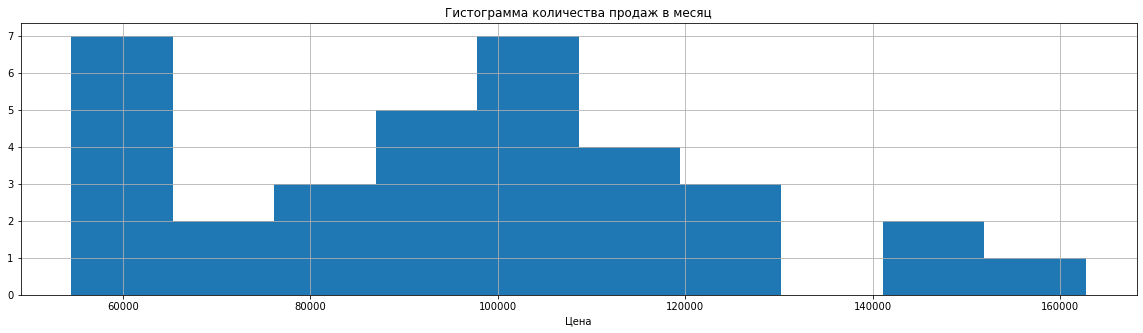

In [175]:
train.groupby('date_block_num').sum()['item_cnt_day'].hist(figsize = (20,5))
plt.title('Гистограмма количества продаж в месяц')
plt.xlabel('Цена')

# 4. Сопоставьте элементов

In [176]:
category_list = list(item_category.item_category_name)

for i in range(1,8):
    category_list[i] = 'Accessories'

for i in range(10,18):
    category_list[i] = 'Consoles'

for i in range(18,25):
    category_list[i] = 'Consoles Games'

for i in range(26,28):
    category_list[i] = 'Phone games'

for i in range(28,32):
    category_list[i] = 'CD games'

for i in range(32,37):
    category_list[i] = 'Card'

for i in range(37,43):
    category_list[i] = 'Movie'

for i in range(43,55):
    category_list[i] = 'Books'

for i in range(55,61):
    category_list[i] = 'Music'

for i in range(61,73):
    category_list[i] = 'Gifts'

for ind in range(73,79):
    category_list[i] = 'Soft'


item_category['category'] = category_list
item_category.head()

,item_category_name,item_category_id,category
0,PC - Гарнитуры/Наушники,0,PC - Гарнитуры/Наушники
1,Аксессуары - PS2,1,Accessories
2,Аксессуары - PS3,2,Accessories
3,Аксессуары - PS4,3,Accessories
4,Аксессуары - PSP,4,Accessories


# 5. Преобразование типов данных 

Конвертируем столбец "дата" из типа "object" в тип "дата"

In [177]:
train['date'] = pd.to_datetime(train.date,format="%d.%m.%Y")
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


Сводка по месяцам в широком формате

In [191]:
train_pivot_table = train.pivot_table(index=['shop_id','item_id'], columns='date_block_num', 
                         values='item_cnt_day',aggfunc='sum').fillna(0.0)
train_pivot_table.head()

date_block_num    0     1    2    3    4    5    6    7    8    9   ...   24  \
shop_id item_id                                                     ...        
0       30       0.0  31.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
        31       0.0  11.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
        32       6.0  10.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
        33       3.0   3.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
        35       1.0  14.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   

date_block_num    25   26   27   28   29   30   31   32   33  
shop_id item_id                                               
0       30       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        31       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        32       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        33       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        35       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 34 columns]

Добавляем категории

In [192]:
train_cleaned = train_pivot_table.reset_index()
train_cleaned['shop_id']= pd.to_numeric(train_cleaned_df['shop_id'])
train_cleaned['item_id']= pd.to_numeric(train_cleaned_df['item_id'])

item_to_cat = items.merge(item_category[['item_category_id','category']], how="inner",
                             on="item_category_id")[['item_id','category']]
train_cleaned = train_cleaned.merge(item_to_cat, how="inner", on="item_id")

Кодируем категории

In [193]:
number = preprocessing.LabelEncoder()
train_cleaned[['category']] = number.fit_transform(train_cleaned_df.category)
train_cleaned = train_cleaned[['shop_id', 'item_id', 'category'] + list(range(34))]
train_cleaned.head()

,shop_id,item_id,category,0,1,2,3,4,5,6,...,24,25,26,27,28,29,30,31,32,33
0,0,30,7,0.0,31.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,30,7,0.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,30,7,6.0,10.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,30,7,3.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,30,7,1.0,14.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 6. Построение моделей

Проверка итогового набора данных

In [195]:
show_data_info(train_cleaned)

-----------------Первые 7 записей----------------------
   shop_id  item_id  category    0     1    2    3    4    5    6  ...   24  \
0        0       30         7  0.0  31.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
1        1       30         7  0.0  11.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
2        2       30         7  6.0  10.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
3        3       30         7  3.0   3.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
4        4       30         7  1.0  14.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
5        5       30         7  0.0   1.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
6        6       30         7  0.0   1.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   

    25   26   27   28   29   30   31   32   33  
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
5  0.0  0.0  0.0 

KeyError: 34

Разделение выборок

In [196]:
X_train = train_cleaned.drop(33, 1)
y_train = train_cleaned[33]
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(401163, 36)
(401163,)
(120349, 36)


In [197]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=42)
print (X_train.shape,  y_train.shape)
print (X_test.shape,  y_test.shape)

(280814, 36) (280814,)
(120349, 36) (120349,)


In [198]:
real_to_predict = test
real_to_predict = test.merge(train_cleaned, how = "left", on = ["shop_id", "item_id"]).fillna(0.0)
real_to_predict.head()

,ID,shop_id,item_id,category,0,1,2,3,4,5,...,24,25,26,27,28,29,30,31,32,33
0,0,5,5037,5.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,5.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,5,5232,5.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Переход на один месяц вперед

In [199]:
d = dict(zip(real_to_predict.columns[4:],list(np.array(list(apply_df.columns[4:])) - 1)))

real_to_predict  = real_to_predict.rename(d, axis = 1)

In [200]:
X_test_fin.head()

,shop_id,item_id,category,-2,-1,0,1,2,3,4,...,22,23,24,25,26,27,28,29,30,31
0,5,5037,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5,5233,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,5,5232,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 6.1  Модель RandomForestRegressor

Список гиперпараметров

In [290]:
params = {"n_estimators" : [100, 300, 500, 700],
          "max_depth" : [3, 5, 7],
          "max_features" : [20, 60, 120]
         }

Подбор гиперпараметров

In [291]:
search_rfr = GridSearchCV(RandomForestRegressor(random_state=1), params).fit(X_train, y_train)
search_rfr.best_params_

{'max_depth': 7, 'max_features': 20, 'n_estimators': 700}

Применнение лучших параметров к модели

In [292]:
model_rfr = search_rfr.best_estimator_

 Оценка качества модели по метрикам

In [293]:
y_pred_rfr = model_rfr.predict(X_test)
show_metrics(y_test, y_pred_rfr)

MSE: 1.7556382131824342
RMSE: 1.3250049860971973
MAE: 0.20683034980313886
Коэффициент детерминации: 0.1653166480715189


 Визуализация реальных и предсказанных значений

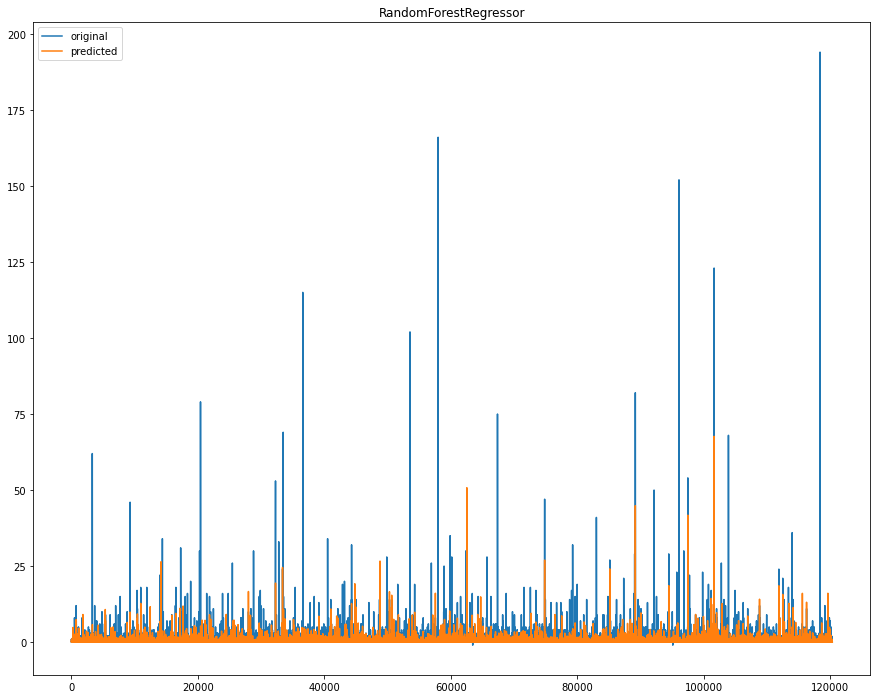

In [294]:
plot_model_results('RandomForestRegressor', y_test, y_pred_rfr)

Предсказания для тестовой выборки

In [204]:
predict_rfr = model_rfr.predict(X_test_fin.iloc[:, (X_test_fin.columns != 'ID') & (X_test_fin.columns != -1)].values)

NameError: name 'model_rfr' is not defined

Нормализуем наш прогноз в пределах [0-20]

In [ ]:
predicted_rfr = pd.DataFrame({'ID':real_to_predict.ID,'item_cnt_month':list(map(lambda x: min(20,max(x,0)),
                                                                                list(predict_rfr)))})
predicted_rfr.head()

Запись результатов в файл для их отправки

In [ ]:
predicted_rfr.to_csv('results/Predict_Sales_rfr.csv',index=False)

## 6.2 XGBRegressor

Список гиперпараметров

In [295]:
params = {"n_estimators" : [100, 350, 600, 850],
          "learning_rate" : [0.001, 0.01, 0.1],
          "max_depth" : [3, 5, 7, 9],
         }

Подбор гиперпараметров

In [ ]:
xgb_search = GridSearchCV(XGBRegressor(random_state=1), params).fit(X_train, y_train)
xgb_search.best_params_

Применнение лучших параметров к модели

In [ ]:
model_xgb = xgb_search.best_estimator_

Оценка качества модели по метрикам

In [297]:
y_pred_xgb = model_xgb.predict(X_test)
show_metrics(y_test, y_pred_xgb)

MSE: 1.7556382131824342
RMSE: 1.3250049860971973
MAE: 0.20683034980313886
Коэффициент детерминации: 0.1653166480715189


 Визуализация реальных и предсказанных значений

In [ ]:
plot_model_results('XGBRegressor', y_test, y_pred_xgb)

Предсказания для тестовой выборки

In [ ]:
predict_xgb = model_xgb.predict(X_test_fin.iloc[:, (X_test_fin.columns != 'ID') & (X_test_fin.columns != -1)].values)

Нормализуем наш прогноз в пределах [0-20]

In [ ]:
predicted_xgb = pd.DataFrame({'ID':real_to_predict.ID,'item_cnt_month':list(map(lambda x: min(20,max(x,0)), 
                                                                                list(predict_xgb))) })
predicted_xgb.head()

Запись результатов в файл для их отправки

In [ ]:
predicted_xgb.to_csv('results/Predict_Sales_xgb.csv',index=False)

## 6.3 GradientBoostingRegressor

In [145]:
model_gbr = GradientBoostingRegressor().fit(X_train, y_train)

 Оценка качества модели по метрикам

In [146]:
y_pred_gbr = model_gbr.predict(X_test)
show_metrics(y_test, y_pred_gbr)

MSE: 1.6763671478488786
RMSE: 1.2947459781165103
MAE: 0.1999600120373134
Коэффициент детерминации: 0.20300450313569784


Визуализация реальных и предсказанных значений

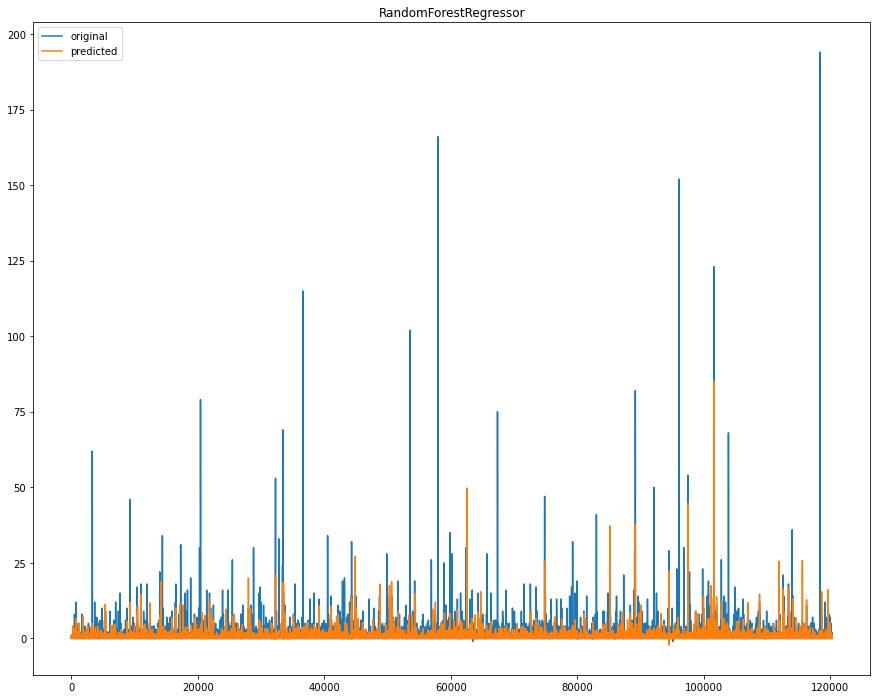

In [147]:
plot_model_results('GradientBoostingRegressor', y_test, y_pred_gbr)

Предсказания для тестовой выборки

In [150]:
predict_gbr = model_gbr.predict(X_test_fin.iloc[:, (X_test_fin.columns != 'ID') & (X_test_fin.columns != -1)].values)

Нормализуем наш прогноз в пределах [0-20]

In [201]:
predicted_gbr = pd.DataFrame({'ID':real_to_predict.ID,'item_cnt_month':list(map(lambda x: min(20,max(x,0)), 
                                                                                list(predict_gbr)))})
predicted_gbr.head()

,ID,item_cnt_month
0,0,0.389756
1,1,0.096661
2,2,0.848103
3,3,0.121121
4,4,0.096661


Запись результатов в файл для их отправки

In [188]:
predicted_gbr.to_csv('results/Predict_Sales_gbr.csv',index=False)

## 6.4 CatBoostRegressor

Список гиперпараметров

In [205]:
params = {
          'learning_rate': [0.01, 0.001, 0.0001],
          'depth': [3, 5, 7], 
          'n_estimators': [100,400,700]
         }

Подбор гиперпараметров

In [303]:
search_cbr = GridSearchCV(CatBoostRegressor(random_state=1, verbose=False), params).fit(X_train, y_train)
search_cbr.best_params_

KeyboardInterrupt: 

Применнение лучших параметров к модели

In [ ]:
model_cbr = search_cbr.best_estimator_

Оценка качества модели по метрикам

In [ ]:
y_pred_cbr = model_rfr.predict(X_test)
show_metrics(y_test, y_pred_cbr)

 Визуализация реальных и предсказанных значений

In [ ]:
plot_model_results('CatBoostRegressor', y_test, y_pred_cbr)

Предсказания для тестовой выборки

In [ ]:
predict_cbr = model_cbr.predict(X_test_fin.iloc[:, (X_test_fin.columns != 'ID') & (X_test_fin.columns != -1)].values)

Нормализуем наш прогноз в пределах [0-20]

In [ ]:
predicted_cbr = pd.DataFrame({'ID':real_to_predict.ID,'item_cnt_month':list(map(lambda x: min(20,max(x,0)), 
                                                                                list(predict_cbr)))})
predicted_cbr.head()

Запись результатов в файл для их отправки

In [ ]:
predicted_cbr.to_csv('results/Predict_Sales_cbr.csv',index=False)